## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
import torch.nn.functional as F

from torch.optim.lr_scheduler import StepLR
from torch.optim import SGD

from net_FC import DualNet
from torch.nn import CrossEntropyLoss
from loss import ContrastiveLoss

from dataset_descriptor import DatasetDescriptor, get_dataloader

import matplotlib.pyplot as plt
import matplotlib.animation as animation


## Setup

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
n_epochs = 250
learning_rate = 1e-3
batch_size = 50

data_all = DatasetDescriptor('data_descriptors.py.npy', 'labels.py.npy', transform_strength=3e-4)
dataset_train, dataset_valid = data_all.generate_train_validation_split()

train_loader = get_dataloader(dataset_train, batch_size=batch_size, shuffle=True)
valid_loader = get_dataloader(dataset_valid, batch_size=batch_size, shuffle=False)
cluster_loader = get_dataloader(data_all, batch_size=batch_size, shuffle=True)
cluster_loader_viz = get_dataloader(data_all, batch_size=batch_size, shuffle=False)

layers = [1080, 1080, 1080, 64]


loss_classification = CrossEntropyLoss()
loss_clustering = ContrastiveLoss()
alpha = 0.15

model = DualNet(layers, n_classes=10, out_dim=2).to(device)
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.7, nesterov=True)
scheduler = StepLR(optimizer=optimizer, step_size=25, gamma=0.5)

accuracy_train = np.zeros(n_epochs)
accuracy_valid = np.zeros(n_epochs)

D = []
L = []

## Train

In [3]:
for n in range(n_epochs):
    print(f"\rEPOCH: [{n + 1} / {n_epochs}]", end='')
    model.train()
    for i, blob in enumerate(train_loader):
        optimizer.zero_grad()
        data, labels = [x.to(device).float() for x in blob]

        predictions, data_mapped = model(data)

        loss =      alpha  * loss_classification(predictions, labels) +\
               (1 - alpha) * loss_clustering(F.tanh(data_mapped), labels)
        
        loss.backward()
        optimizer.step()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        # Train accuracy
        N = 0
        C = 0
        for i, blob in enumerate(train_loader):
            data, targets = [x.to(device=device).float() for x in blob]
            predictions, _ = model(data)
            C += torch.sum(torch.argmax(predictions, dim=1) == torch.argmax(targets, dim=1))
            N += predictions.shape[0]
        accuracy_train[n] = 100 * C / N

        # Validation accuracy
        N = 0
        C = 0
        for i, blob in enumerate(valid_loader):
            data, targets = [x.to(device=device).float() for x in blob]
            predictions, _ = model(data)
            C += torch.sum(torch.argmax(predictions, dim=1) == torch.argmax(targets, dim=1))
            N += predictions.shape[0]
        accuracy_valid[n] = 100 * C / N

        # Clustering
        data_mapped = np.zeros((len(data_all), 2))
        labels_mapped = np.zeros(len(data_all))

        idx = 0
        for i, blob in enumerate(train_loader):
            with torch.no_grad():
                data, labels = [x.to(device).float() for x in blob]
                B = data.shape[0]
                a, dm = model(data)
                labels = torch.argmax(labels, dim=1).cpu().numpy()
                dm = (dm).cpu().numpy()
                labels_mapped[idx: idx + B] = labels
                data_mapped[idx: idx + B, :] = dm
                idx += B
        D.append(data_mapped)
        L.append(labels_mapped)    
print()

EPOCH: [250 / 250]


## Cluster animation

0.080

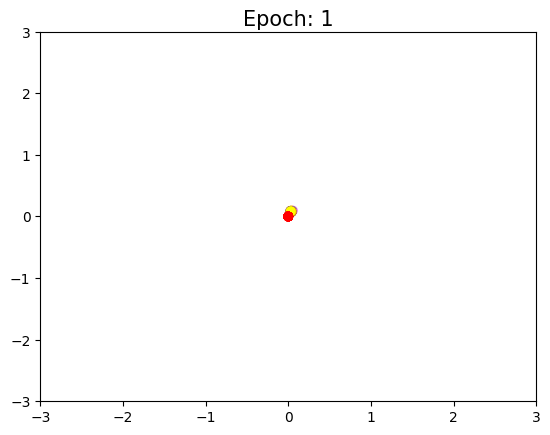

In [4]:
D_pre = np.array(D)
D_interp = np.zeros((2500, 144, 2))
for j in range(144):
    for i in range(2):
        D_interp[:, j, i] = np.interp(np.linspace(0, len(D), 2500), np.arange(len(D)), D_pre[:, j, i])

D_interp = D_interp[:1250, :, :]


frames = D_interp.shape[0]
L_c = []
for l in L: L_c.append([int(x) for x in l])

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'black', 'gold', 'pink']
c_i = [colors[l] for l in L_c[0]]

centroids = np.zeros((frames, len(data_all.classes), 2))
for f in range(frames):
    for i, c in enumerate(data_all.classes):
        centroids[f, i, :] = np.median(D_interp[f, L[i] == i, :], axis=0)

fig, ax = plt.subplots()
s = ax.scatter([], [])
t = ax.text(0, 3.1, 'Start', ha='center', fontsize=15)

lines = []
scatters = []
for i in range(len(data_all.classes)):
    line, = ax.plot([], [], c=colors[i])
    lines.append(line)
    s = ax.scatter([], [], c=colors[i])
    scatters.append(s)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)


def update(i):
    print(f"\r{100 * (i + 1) / frames}", end='')
    t.set_text(f"Epoch: {int(i // (D_interp.shape[0] / len(D)) + 1)}")
    for j, _ in enumerate(lines):
        lines[j].set_xdata(centroids[:i, j, 0])
        lines[j].set_ydata(centroids[:i, j, 1])
        lines[j].set_alpha(0.15)

    s.set_offsets(np.column_stack([D_interp[i, :, 0], D_interp[i, :, 1]]))
    s.set_facecolors(c_i)
    
        
ani = animation.FuncAnimation(fig, update, frames=frames, interval=10)
ani.save('set.gif', writer='pillow')

## Accuracy during training

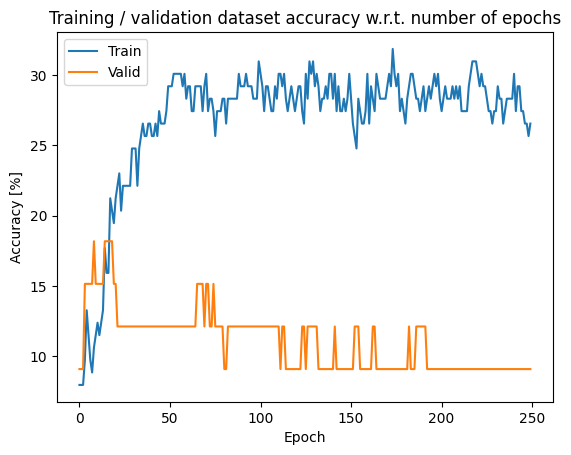

In [5]:
plt.figure()
plt.plot(accuracy_train)
plt.plot(accuracy_valid)
plt.legend(['Train', 'Valid'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Training / validation dataset accuracy w.r.t. number of epochs')
plt.savefig('acc_progress.png')
plt.show()